In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import time
import xarray as xr

#### File list and Dates

In [2]:
#path to netCDF files *NOTE, only want int.nc (saved as integers in [cm])
path = '/srv/shared/deep_stac/data/snowdepth/netcdf/20*/*int.nc'

#filelist, 2015 & 2017
flist = glob.glob(path, recursive=True)

#parses dates, stored as pandas datetime type in list
fparse = [d.split('/')[-1] for d in flist] #splits fname on '/' saves last
fparse = [d.split('_')[0] for d in fparse] #splitting fname on '_' and saves first
dates = pd.to_datetime(fparse) #pandas datetime variable of all lidar dates
# dates

#### Load Xarray Dataset of Snow Depth Lidar
    ds = entire dataset: 10 lidar flights from 2015, 9 lidar flights from 2017
    
    dimensions = label given to coordinate values
    coordinates = values in a dimension, stored as python dictionaries
    
    Note - 
        dates = pandas datetime type computed above
        time = new coordinate assigned to xarray, labels verically by giving a 'time' dimention 

In [3]:
#load xarray (*note, gives an error, it's okay!)
ds=xr.open_mfdataset(flist , concat_dim='flights', chunks={'x':1000, 'y':1000}) #dataset
ds.close() #closes large dataset, but you can still use ds

#add 'time' coordinate #note, by default this populates with a dimesion called 'time'
ds['time'] = (['time'], dates)
ds = ds.assign_coords(time=ds.time)
ds #entire dataset!

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  coords=coords)


<xarray.Dataset>
Dimensions:              (flights: 19, time: 19, x: 17569, y: 17002)
Coordinates:
  * x                    (x) float64 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
  * y                    (y) float64 4.179e+06 4.179e+06 ... 4.23e+06 4.23e+06
  * time                 (time) datetime64[ns] 2015-04-03 ... 2017-01-29
Dimensions without coordinates: flights
Data variables:
    transverse_mercator  (flights) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b''
    Band1                (flights, y, x) float32 dask.array<shape=(19, 17002, 17569), chunksize=(1, 1000, 1000)>
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 2.4.1, released 2019/03/15
    history:             Wed Sep 11 15:41:18 2019: GDAL CreateCopy( /srv/shar...

#### select xarray by year

In [ ]:
#xarray for 2015
ds15 = ds.sel(time='2015')
# print('~~~~2015 lidar flights in xarray~~~~', ds15)

#xarray for 2017
ds17 = ds.sel(time='2017')
# print('\n\n\n~~~~2017 lidar flights in xarray~~~~', ds17)

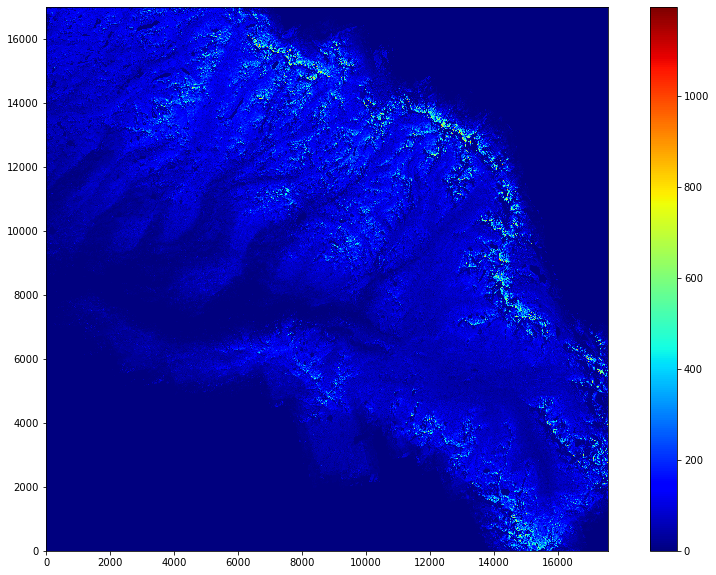

In [4]:
# ds15 = ds.sel(time='2015')
m = ds.sel(time='2015').Band1.mean(dim='flights')

# mean_sd_15 = ds15.Band1.mean(dim='flights')
fig = plt.figure(figsize=(15, 10))
plt.imshow(m, origin='lower', cmap='jet')#, vmin=.01, vmax=2.0)
plt.colorbar()
plt.show()




# variance in snow depth
# varsn = ds.Band1.var(dim='time') #compute variance on every pixel in the time dimention 
# varsn = np.where(varsn>.001, varsn, np.nan) # filters everything greater than 1mm (i.e gives alpha bg)
# fig = plt.figure(figsize=(15, 10))
# plt.imshow(varsn[::-1,:], cmap='jet', vmin=.05, vmax=1.0) #[::-1,:] - reverses it
# plt.title('snow depth [50m] variance, 2013-2016')
# plt.colorbar()
# plt.savefig('figs/var_13-16', dpi=600)

In [ ]:
# topo = '/home/jovyan/shared/deep_stac/data/topo.nc'
# dstopo = xr.open_dataset(topo)
# dstopo.close()
# dstopo.expand_dims('time')
# dstopo